## Request to Test

In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# paths
CSV_PATH = Path("RequestToTest.csv")   # change if needed
OUT_DIR = Path("./outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# output files
MONTHLY_PNG = OUT_DIR / "request_to_test_monthly_avg.png"
REGION_PNG  = OUT_DIR / "request_to_test_by_region.png"

In [59]:

# Load data

df_raw = pd.read_csv(CSV_PATH)
df = df_raw.copy()

In [60]:

# Standardize column names

df.columns = (
    df.columns
      .astype(str)
      .str.strip()
      .str.replace(" ", "_")
      .str.lower()
)


# Detect likely columns

possible_provider    = ["provider_name","provider","trust","organisation","organization","org_name"]
possible_region_name = ["region_name","regionname","region_full_name","region_full"]
possible_region_code = ["region","region_code","nhs_region_code"]

provider_col     = next((c for c in df.columns if c in possible_provider), None)
region_name_col  = next((c for c in df.columns if c in possible_region_name), None)
region_code_col  = next((c for c in df.columns if c in possible_region_code), None)

In [61]:

# Detect numeric metric column

def score_val(name: str, s: pd.Series) -> float:
    n = name.lower()
    score = 0
    if "median" in n or "med" in n:
        score += 2
    if any(k in n for k in ["day","days","request_to_test","d2d"]):
        score += 2
    score += min(s.nunique(dropna=True), 5) * 0.1
    return score

value_candidates = []
for c in df.columns:
    if c == "__date__":
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        value_candidates.append(c)
    else:
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().mean() > 0.8:
            df[c] = coerced
            value_candidates.append(c)

if not value_candidates:
    raise ValueError("No numeric column found for the median-days metric.")

best_val_col = max(value_candidates, key=lambda c: score_val(c, df[c]))

### Yearly Trend

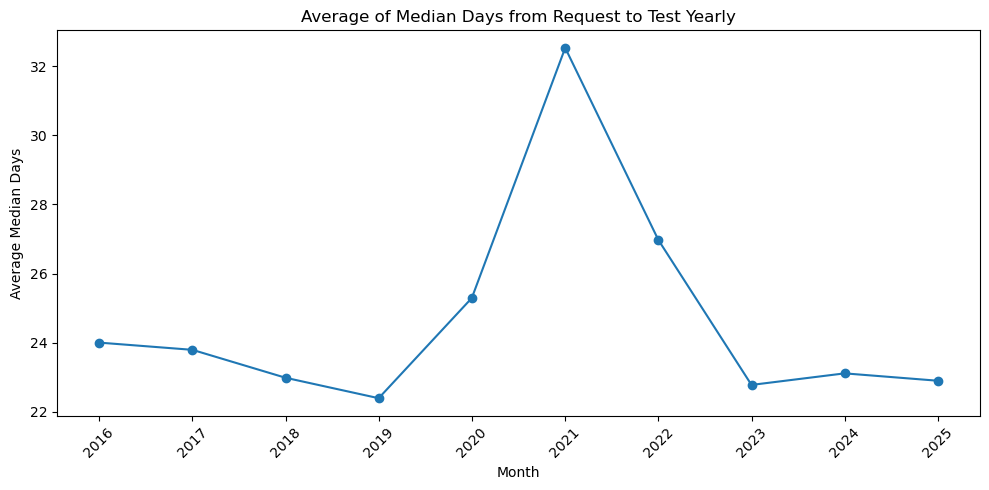

In [62]:

# Yearly average line chart

monthly_avg = (
    tidy.assign(year_month=tidy["date"].dt.to_period("M").dt.to_timestamp())
        .groupby("year_month", as_index=False)["median_days"]
        .mean()
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg["year_month"], monthly_avg["median_days"], marker="o")
plt.title("Average of Median Days from Request to Test Yearly")
plt.xlabel("Month")
plt.ylabel("Average Median Days")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(str(MONTHLY_PNG), dpi=200, bbox_inches="tight")
plt.show()   
plt.close()

### Regional Averages

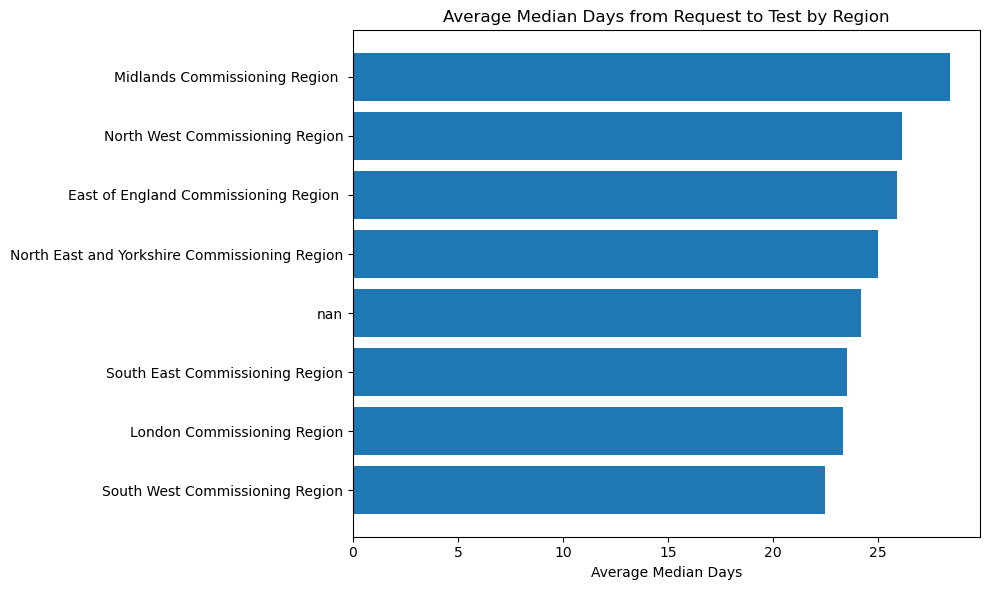

In [63]:

# Region averages

avg_per_region = None

if provider_col:
    if not region_name_col:
        if region_code_col:
            region_name_col = "regionname"
            df[region_name_col] = df[region_code_col].copy()
        else:
            region_name_col = "regionname"
            df[region_name_col] = np.nan

    provider_to_region = (
        df.dropna(subset=[region_name_col])
          .groupby(provider_col)[region_name_col]
          .agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])
          .to_dict()
    )

    df[region_name_col] = df.apply(
        lambda r: provider_to_region.get(r[provider_col], r[region_name_col]),
        axis=1
    )

    df["median_days_req_to_test"] = df[best_val_col]
    avg_per_region = (
        df.groupby(region_name_col, dropna=False)["median_days_req_to_test"]
          .mean()
          .reset_index()
          .sort_values("median_days_req_to_test")
    )

    if not avg_per_region.empty:
        plt.figure(figsize=(10, 6))
        plt.barh(avg_per_region[region_name_col].astype(str),
                 avg_per_region["median_days_req_to_test"])
        plt.xlabel("Average Median Days")
        plt.title("Average Median Days from Request to Test by Region")
        plt.tight_layout()
        plt.savefig(str(REGION_PNG), dpi=200, bbox_inches="tight")
        plt.show()   # <-- show in notebook
        plt.close()

In [64]:

# Summary
print("Detected date column:", date_col)
print("Detected metric column:", best_val_col)
print("Monthly chart saved to:", MONTHLY_PNG.resolve())
if provider_col and avg_per_region is not None and not avg_per_region.empty:
    print("Region chart saved to:", REGION_PNG.resolve())
else:
    print("Region chart skipped (provider/region data not sufficient).")

Detected date column: date
Detected metric column: median_days_request_to_test
Monthly chart saved to: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\request_to_test_monthly_avg.png
Region chart saved to: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\request_to_test_by_region.png


### Request to Test Yearly Trend NHS vs Private

In [65]:
# Detect provider column and classify NHS vs Private
common_provider_cols = ["provider_name", "provider", "trust", "organisation", "organization", "org_name"]
prov_col_req = next((c for c in df_req.columns if c in common_provider_cols), None)
if prov_col_req is None:
    prov_col_req = next((c for c in df_req.columns if "provider" in c), None)
if prov_col_req is None:
    raise ValueError("Could not find a provider column.")

nhs_pattern = re.compile(r"\bnhs\b|national\s+health(\s+service)?", re.IGNORECASE)

def classify_provider(name) -> str:
    if pd.isna(name):
        return "Unknown"
    return "NHS" if nhs_pattern.search(str(name)) else "Private"

df_req["provider_type"] = df_req[prov_col_req].apply(classify_provider)


In [66]:
# Detect value column (median days for request->test)
def score_value_col(name: str, s: pd.Series) -> float:
    n = name.lower()
    score = 0.0
    if "median" in n: score += 2
    if "request" in n or "req" in n or "d2d" in n: score += 2
    if "day" in n or "days" in n: score += 1
    score += min(s.nunique(dropna=True), 5) * 0.1
    return score

numeric_like = {}
for c in df_req.columns:
    if c in {date_col_req, "provider_type"}:
        continue
    s = pd.to_numeric(df_req[c], errors="coerce")
    if s.notna().mean() > 0.6:
        numeric_like[c] = s

if not numeric_like:
    raise ValueError("No numeric-like columns found for the metric.")

req_val_col = max(numeric_like.keys(), key=lambda c: score_value_col(c, numeric_like[c]))
df_req[req_val_col] = pd.to_numeric(df_req[req_val_col], errors="coerce")


In [67]:
# Build yearly averages by provider type

# ensure date column is datetime
df_req[date_col_req] = pd.to_datetime(df_req[date_col_req], errors="coerce", dayfirst=True)

# now extract year
df_req["year"] = df_req[date_col_req].dt.year

# group yearly averages
req_yearly = (
    df_req
    .dropna(subset=[date_col_req, req_val_col, "year"])
    .groupby(["year", "provider_type"])[req_val_col]
    .mean()
    .reset_index()
    .sort_values(["year", "provider_type"])
    .rename(columns={req_val_col: "median_days"})
)

req_yearly.to_csv(OUT_CSV_REQUEST_YEARLY, index=False)
req_yearly.head()



,year,provider_type,median_days
0,2016,NHS,24.519577
1,2016,Private,14.861111
2,2017,NHS,24.283421
3,2017,Private,17.253906
4,2018,NHS,24.638255


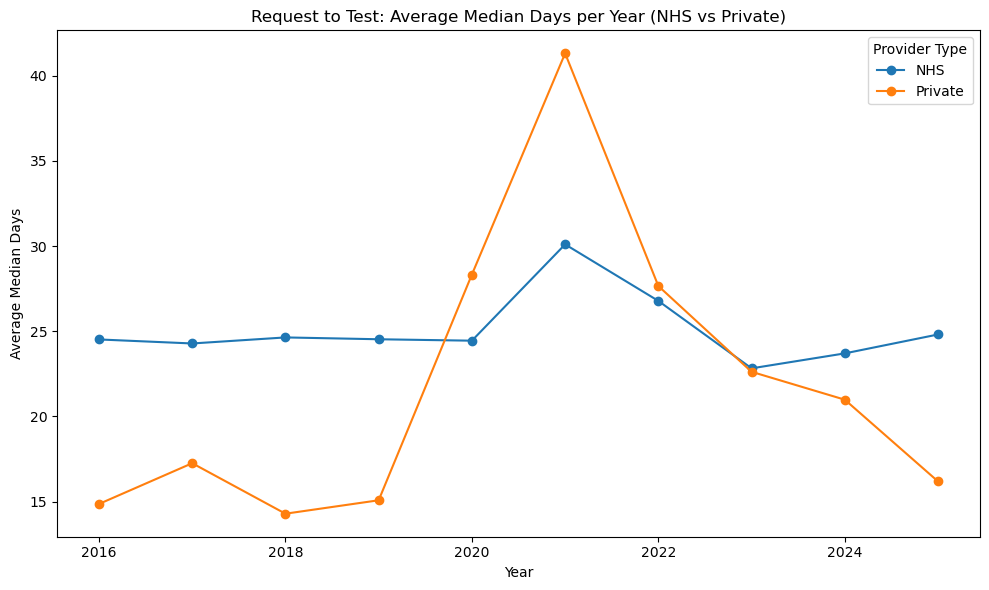

Detected date column: date
Detected metric column: median_days_request_to_test
Yearly table saved to: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\request_to_test_yearly_averages.csv
Figure saved to: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\request_to_test_yearly_nhs_vs_private.png


In [68]:
#  Plot Request -> Test (yearly, NHS vs Private)
plt.figure(figsize=(10, 6))

for ptype in ["NHS", "Private", "Unknown"]:
    subset = req_yearly[req_yearly["provider_type"] == ptype]
    if subset.empty:
        continue
    plt.plot(subset["year"], subset["median_days"], marker="o", label=ptype)

plt.title("Request to Test: Average Median Days per Year (NHS vs Private)")
plt.xlabel("Year")
plt.ylabel("Average Median Days")
plt.legend(title="Provider Type")
plt.tight_layout()
plt.savefig(OUT_IMG_REQUEST_YEARLY, dpi=200, bbox_inches="tight")
plt.show()

print("Detected date column:", date_col_req)
print("Detected metric column:", req_val_col)
print("Yearly table saved to:", OUT_CSV_REQUEST_YEARLY.resolve())
print("Figure saved to:", OUT_IMG_REQUEST_YEARLY.resolve())


### Request to Test Monthly Trend NHS vs Private

In [ ]:
# Detect and parse date column
date_candidates = [c for c in df_req.columns if "date" in c]
if not date_candidates:
    raise ValueError("No date-like column found (expected a column containing 'date').")

best_col = None
best_cov = -1.0
for c in date_candidates:
    parsed = pd.to_datetime(df_req[c], errors="coerce", dayfirst=True)
    cov = parsed.notna().mean()
    if cov > best_cov and parsed.nunique(dropna=True) >= 3:
        best_cov = cov
        best_col = c

if best_col is None:
    raise ValueError("Could not parse a usable date column.")

df_req[best_col] = pd.to_datetime(df_req[best_col], errors="coerce", dayfirst=True)
date_col_req = best_col


In [ ]:
# Detect value column (median days for request->test)

def score_value_col(name: str, s: pd.Series) -> float:
    n = name.lower()
    score = 0.0
    if "median" in n: score += 2
    if "request" in n or "req" in n or "d2d" in n: score += 2
    if "day" in n or "days" in n: score += 1
    score += min(s.nunique(dropna=True), 5) * 0.1
    return score

numeric_like = {}
for c in df_req.columns:
    if c == date_col_req or c == "provider_type":
        continue
    s = pd.to_numeric(df_req[c], errors="coerce")
    if s.notna().mean() > 0.6:
        numeric_like[c] = s

if not numeric_like:
    raise ValueError("No numeric-like columns found for the metric.")

req_val_col = max(numeric_like.keys(), key=lambda c: score_value_col(c, numeric_like[c]))
df_req[req_val_col] = pd.to_numeric(df_req[req_val_col], errors="coerce")


In [71]:
# Build monthly averages by provider type
df_req["year_month"] = df_req[date_col_req].dt.to_period("M").dt.to_timestamp()

req_monthly = (
    df_req
    .dropna(subset=[date_col_req, req_val_col])
    .groupby(["year_month", "provider_type"])[req_val_col]
    .mean()
    .reset_index()
    .sort_values(["year_month", "provider_type"])
)

# save summary table
req_monthly.rename(columns={req_val_col: "median_days"}, inplace=True)
req_monthly.to_csv(OUT_CSV_REQUEST, index=False)

# quick preview
req_monthly.head()


,year_month,provider_type,median_days
0,2016-04-01,NHS,26.205674
1,2016-04-01,Private,15.000000
2,2016-05-01,NHS,24.375000
3,2016-05-01,Private,14.875000
4,2016-06-01,NHS,24.209220


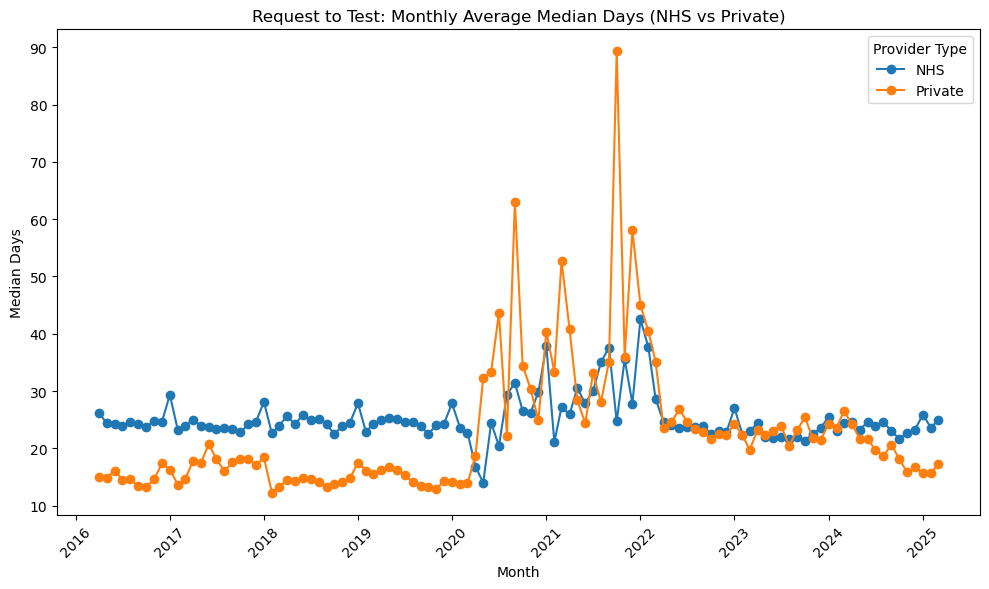

Detected date column: date
Detected metric column: median_days_request_to_test
Monthly table saved to: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\request_to_test_monthly_averages.csv
Figure saved to: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\request_to_test_nhs_vs_private.png


In [72]:
# Plot Request -> Test (NHS vs Private)
plt.figure(figsize=(10, 6))

for ptype in ["NHS", "Private", "Unknown"]:
    subset = req_monthly[req_monthly["provider_type"] == ptype]
    if subset.empty:
        continue
    plt.plot(subset["year_month"], subset["median_days"], marker="o", label=ptype)

plt.title("Request to Test: Monthly Average Median Days (NHS vs Private)")
plt.xlabel("Month")
plt.ylabel("Median Days")
plt.xticks(rotation=45)
plt.legend(title="Provider Type")
plt.tight_layout()
plt.savefig(OUT_IMG_REQUEST, dpi=200, bbox_inches="tight")
plt.show()

print("Detected date column:", date_col_req)
print("Detected metric column:", req_val_col)
print("Monthly table saved to:", OUT_CSV_REQUEST.resolve())
print("Figure saved to:", OUT_IMG_REQUEST.resolve())
